<a href="https://colab.research.google.com/github/bdenli/mit_capstone/blob/main/malaria_detection_keras_basak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
import os, shutil
os.chdir('/content/drive/MyDrive/mit_capstone')
!pwd

/content/drive/MyDrive/mit_capstone


In [ ]:
!unzip /content/drive/MyDrive/mit_capstone/cell_images.zip

In [19]:
print(os.listdir('/content/drive/MyDrive/mit_capstone/cell_images'))
print(os.listdir('/content/drive/MyDrive/mit_capstone/cell_images/train'))

['train', 'test']
['parasitized', 'uninfected']


In [123]:
import PIL
import PIL.Image

import pandas

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, LeakyReLU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
print(tf.__version__)

2.11.0


## Load Datasets

In [124]:
batch_size = 8
img_height = 64
img_width = 64

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/MyDrive/mit_capstone/cell_images/train',
  validation_split=0.2,
  subset="both",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/MyDrive/mit_capstone/cell_images/test',
  validation_split=None,
  subset=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=256)

class_names = train_ds.class_names
print(class_names)

Found 24958 files belonging to 2 classes.
Using 19967 files for training.
Using 4991 files for validation.
Found 2600 files belonging to 2 classes.
['parasitized', 'uninfected']


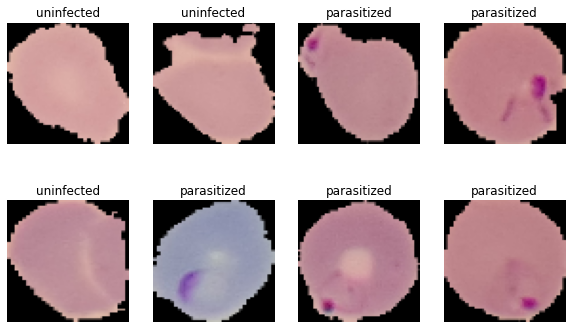

In [125]:
plt.figure(figsize=(10, 6))
for images, labels in train_ds.take(1):
  for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [126]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8, 64, 64, 3)
(8,)


In [127]:
# We need to normalize the images pixel values from range [0 255] to range [0 to 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

image_train_batch, labels_train_batch = next(iter(normalized_train_ds))

print("image min value =", np.min(image_train_batch), "image max value =",np.max(image_train_batch))

image min value = 0.0 image max value = 0.9037378


In [128]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()
# set random seed for numpy, random and tensorflow
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

# number of classes
num_classes = 2

# convoluation model setup (similar to LeNet)
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [129]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [130]:
model.summary(model.build((None, 64,64,3)))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 32)        9

In [ ]:

history_model = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
2496/2496 [==============================] - 66s 26ms/step - loss: 0.1907 - accuracy: 0.9125 - val_loss: 0.1099 - val_accuracy: 0.9645
Epoch 2/10
2496/2496 [==============================] - 64s 26ms/step - loss: 0.0736 - accuracy: 0.9755 - val_loss: 0.0716 - val_accuracy: 0.9766
Epoch 3/10
1478/2496 [================>.............] - ETA: 20s - loss: 0.0665 - accuracy: 0.9766

In [ ]:
# Plotting the training accuracies
dict_hist = history_model.history

print(dict_hist.keys())
print(len(dict_hist['accuracy']), len(dict_hist['val_accuracy']))

print(dict_hist['accuracy'])

list_exp = [i for i in range(1, len(dict_hist['accuracy'])+1)]

plt.figure(figsize = (8, 8))
plt.plot(list_exp, dict_hist['accuracy'], ls = '--', label = 'accuracy')
plt.plot(list_exp, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [70]:
# You can also evaluate or predict on a dataset.
print("Evaluate")
result = model.evaluate(test_ds)
dict(zip(model.metrics_names, result))

Evaluate
325/325 [==============================] - 7s 22ms/step - loss: 0.0484 - accuracy: 0.9831


{'loss': 0.048421718180179596, 'accuracy': 0.9830769300460815}

In [121]:
test_predictions_logit = np.empty((0,2))
test_labels = np.empty([0])
for batch_test_image, batch_test_labels in test_ds:
    test_predictions_logit = np.append(test_predictions_logit,model.predict(batch_test_image), axis=0)
    test_labels = np.append(test_labels,batch_test_labels.numpy(),axis=0)

test_predictions = np.argmax(test_predictions_logit, axis = -1)

print(test_predictions_logit.shape)

2/2 [==============================] - 0s 7ms/step
(2600, 2)


              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      1300
         1.0       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



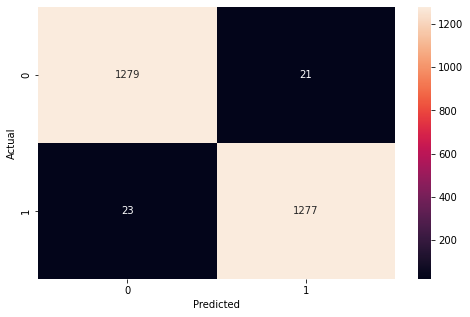

In [122]:
# Importing required functions

from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

# Printing the classification report

print(classification_report(test_labels, test_predictions))

# Plotting the heatmap using confusion matrix

cm = confusion_matrix(test_labels, test_predictions)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f')

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()